In [1]:
import itertools
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
%matplotlib inline

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "cleft"],
    "Agreement": ["number"],
    "Garden-Path Effects": ["npz", "mvrr"],
    "Gross Syntactic State": ["subordination"],
    "Center Embedding": ["center"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
# Exclusions
exclude_suite_re = re.compile(r"^fgd-embed[34]|^gardenpath|^nn-nv")
exclude_models = ["1gram", "ngram", "ngram-no-rand"]

In [4]:
ngram_models = ["1gram", "ngram", "ngram-single"]
baseline_models = ngram_models + ["random"]

# Models for which we designed a controlled training regime
controlled_models = ["ordered-neurons", "vanilla", "rnng"]

### Load

In [5]:
ppl_data_path = Path("../data/raw/perplexity.csv")
test_suite_results_path = Path("../data/raw/test_suite_results")

In [6]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
perplexity_df.index.set_names("model_name", level=0, inplace=True)

results_df = pd.concat([pd.read_csv(f) for f in test_suite_results_path.glob("*.csv")])

# Split model_id into constituent parts
model_ids = results_df.model.str.split("_", expand=True).rename(columns={0: "model_name", 1: "corpus", 2: "seed"})
results_df = pd.concat([results_df, model_ids], axis=1).drop(columns=["model"])
results_df["seed"] = results_df.seed.fillna("0").astype(int)

# Exclude test suites
exclude_filter = results_df.suite.str.contains(exclude_suite_re)
print("Dropping %i results / %i suites due to exclusions:"
      % (exclude_filter.sum(), len(results_df[exclude_filter].suite.unique())))
print(" ".join(results_df[exclude_filter].suite.unique()))
results_df = results_df[~exclude_filter]

# Exclude models
exclude_filter = results_df.model_name.isin(exclude_models)
print("Dropping %i results due to dropping models:" % exclude_filter.sum(), list(results_df[exclude_filter].model_name.unique()))
results_df = results_df[~exclude_filter]

# Add tags
results_df["tag"] = results_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)
tags_missing_circuit = set(results_df.tag.unique()) - set(tag_to_circuit.keys())
if tags_missing_circuit:
    print("Tags missing circuit: ", ", ".join(tags_missing_circuit))

Dropping 14663 results / 3 suites due to exclusions:
fgd-embed3 nn-nv-rpl fgd-embed4
Dropping 169388 results due to dropping models: ['1gram', 'ngram', 'ngram-no-rand']


In [7]:
results_df.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit
0,subordination_orc-orc,0,True,gpt-2,,0,subordination,Gross Syntactic State
1,subordination_orc-orc,1,True,gpt-2,,0,subordination,Gross Syntactic State
2,subordination_orc-orc,2,True,gpt-2,,0,subordination,Gross Syntactic State
3,subordination_orc-orc,3,True,gpt-2,,0,subordination,Gross Syntactic State
4,subordination_orc-orc,4,True,gpt-2,,0,subordination,Gross Syntactic State


In [8]:
# Average across seeds of each baseline model, since we're only interested in baseline aggregate behavior.
#
# (For ngram, the only difference between "seeds" of these model types are random differences in tie-breaking decisions.)
# (For random, different "seeds" correspond to different random samples.)
#
# If we didn't collapse before averaging quantities across seeds (e.g. average score for a test suite),
# we would likely vastly under-estimate the mean.

for baseline_model in baseline_models:
    # Create a synthetic results_df with one ngram model, where each item is correct if more than half of
    # the ngram seeds vote.
    baseline_results_df = (results_df[results_df.model_name == baseline_model].copy().groupby(["model_name", "corpus", "suite", "item", "tag", "circuit"]).agg({"correct": "mean"}) > 0.5).reset_index()
    baseline_results_df["seed"] = 0
    
    # Drop existing model results.
    results_df = pd.concat([results_df[~(results_df.model_name == baseline_model)],
                            baseline_results_df], sort=True)

### Checks

In [9]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model_name", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    #raise ValueError("Each model--corpus--seed must have perplexity data.")

Missing perplexity results for:
{('gpt-2', '', 0),
 ('gpt-2-xl', '', 0),
 ('grnn', '', 0),
 ('jrnn', '', 0),
 ('random', '', 0),
 ('transformer-xl', '', 0)}


In [10]:
# Every model--corpus--seed should have results for all test suite items.
item_list = {model_key: set(results.suite)
             for model_key, results in results_df.groupby(["model_name", "corpus", "seed"])}
not_shared = set()
for k1, k2 in itertools.combinations(item_list.keys(), 2):
    l1, l2 = item_list[k1], item_list[k2]
    if l1 != l2:
        print("SyntaxGym test suite results for %s and %s don't match" % (k1, k2))
        print("\tIn %s but not in %s:\n\t\t%s" % (k2, k1, l2 - l1))
        print("\tIn %s but not in %s:\n\t\t%s" % (k1, k2, l1 - l2))
        print()
        
        not_shared |= l2 - l1
        not_shared |= l1 - l2

if len(not_shared) > 0:
    to_drop = results_df[results_df.suite.isin(not_shared)]
    print("Dropping these test suites (%i rows) for now. Yikes:" % len(to_drop))
    print(not_shared)
    results_df = results_df[~results_df.suite.isin(not_shared)]
else:
    print("OK")

OK


In [11]:
# Second sanity check: same number of results per model--corpus--seed
result_counts = results_df.groupby(["model_name", "corpus", "seed"]).item.count()
if len(result_counts.unique()) > 1:
    print("WARNING: Some model--corpus--seed combinations have more result rows than others.")
    print(result_counts)

## Main analyses

### Global settings

e.g. to maintain consistent hues across model graphs, etc.

In [12]:
model_order = sorted(set(results_df.model_name))
corpus_order = ["bllip-lg", "bllip-md", "bllip-sm", "bllip-xs"]
circuit_order = sorted([c for c in results_df.circuit.dropna().unique()])

### Data prep

In [13]:
suites_df = results_df.groupby(["model_name", "corpus", "seed", "suite"]).correct.mean().reset_index()
suites_df["tag"] = suites_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
suites_df["circuit"] = suites_df.tag.map(tag_to_circuit)

# For controlled evaluation:
# Compute a model's test suite accuracy relative to the mean accuracy on this test suite.
# Only compute this on controlled models.
def get_controlled_mean(suite_results):
    return suite_results[suite_results.model_name.isin(controlled_models)].correct.mean()
suite_means = suites_df.groupby("suite").apply(get_controlled_mean)
suites_df["correct_delta"] = suites_df.apply(lambda r: r.correct - suite_means.loc[r.suite] if r.model_name in controlled_models else None, axis=1)

In [14]:
# Join PPL and accuracy data.
joined_data = suites_df.groupby(["model_name", "corpus", "seed"])[["correct", "correct_delta"]].agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

,model_name,corpus,seed,correct,correct_delta,pid,test_loss,test_ppl
0,gpt-2,,0,0.784176,NaN,NaN,NaN,NaN
1,gpt-2-xl,,0,0.842415,NaN,NaN,NaN,NaN
2,grnn,,0,0.551400,NaN,NaN,NaN,NaN
3,jrnn,,0,0.562679,NaN,NaN,NaN,NaN
4,ordered-neurons,bllip-lg,111,0.486190,0.044844,NaN,4.03,56.38


In [15]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = suites_df.groupby(["model_name", "corpus", "seed", "circuit"])[["correct", "correct_delta"]].agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model_name", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model_name,corpus,seed,circuit,correct,correct_delta,pid,test_loss,test_ppl
0,gpt-2,,0,Agreement,0.736842,NaN,NaN,NaN,NaN
1,gpt-2,,0,Center Embedding,0.892857,NaN,NaN,NaN,NaN
2,gpt-2,,0,Garden-Path Effects,0.880952,NaN,NaN,NaN,NaN
3,gpt-2,,0,Gross Syntactic State,0.891304,NaN,NaN,NaN,NaN
4,gpt-2,,0,Licensing,0.657895,NaN,NaN,NaN,NaN


In [47]:
# Analyze stability to modification.
def has_modifier(ts):
    if ts.endswith(("_modifier", "_mod")):
        return True
    else:
        return None
suites_df["has_modifier"] = suites_df.suite.transform(has_modifier)

# Mark "non-modifier" test suites
modifier_ts = suites_df[suites_df.has_modifier == True].suite.unique()
no_modifier_ts = [re.sub(r"_mod(ifier)?$", "", ts) for ts in modifier_ts]
suites_df.loc[suites_df.suite.isin(no_modifier_ts), "has_modifier"] = False
# Store subset of test suites which have definite modifier/no-modifier marking
suites_df_mod = suites_df[~(suites_df.has_modifier.isna())].copy()
# Get base test suite (without modifier/no-modifier marking)
suites_df_mod["test_suite_base"] = suites_df_mod.suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
suites_df_mod.head()

,model_name,corpus,seed,suite,correct,tag,circuit,correct_delta,has_modifier,test_suite_base
0,gpt-2,,0,center_embed,0.928571,center,Center Embedding,NaN,False,center_emb
1,gpt-2,,0,center_embed_mod,0.857143,center,Center Embedding,NaN,True,center_emb
2,gpt-2,,0,cleft,1.000000,cleft,Long-Distance Dependencies,NaN,False,cleft
3,gpt-2,,0,cleft_modifier,0.925000,cleft,Long-Distance Dependencies,NaN,True,cleft
8,gpt-2,,0,mvrr,0.785714,mvrr,Garden-Path Effects,NaN,False,v


### Baseline sanity checks

No handles with labels found to put in legend.


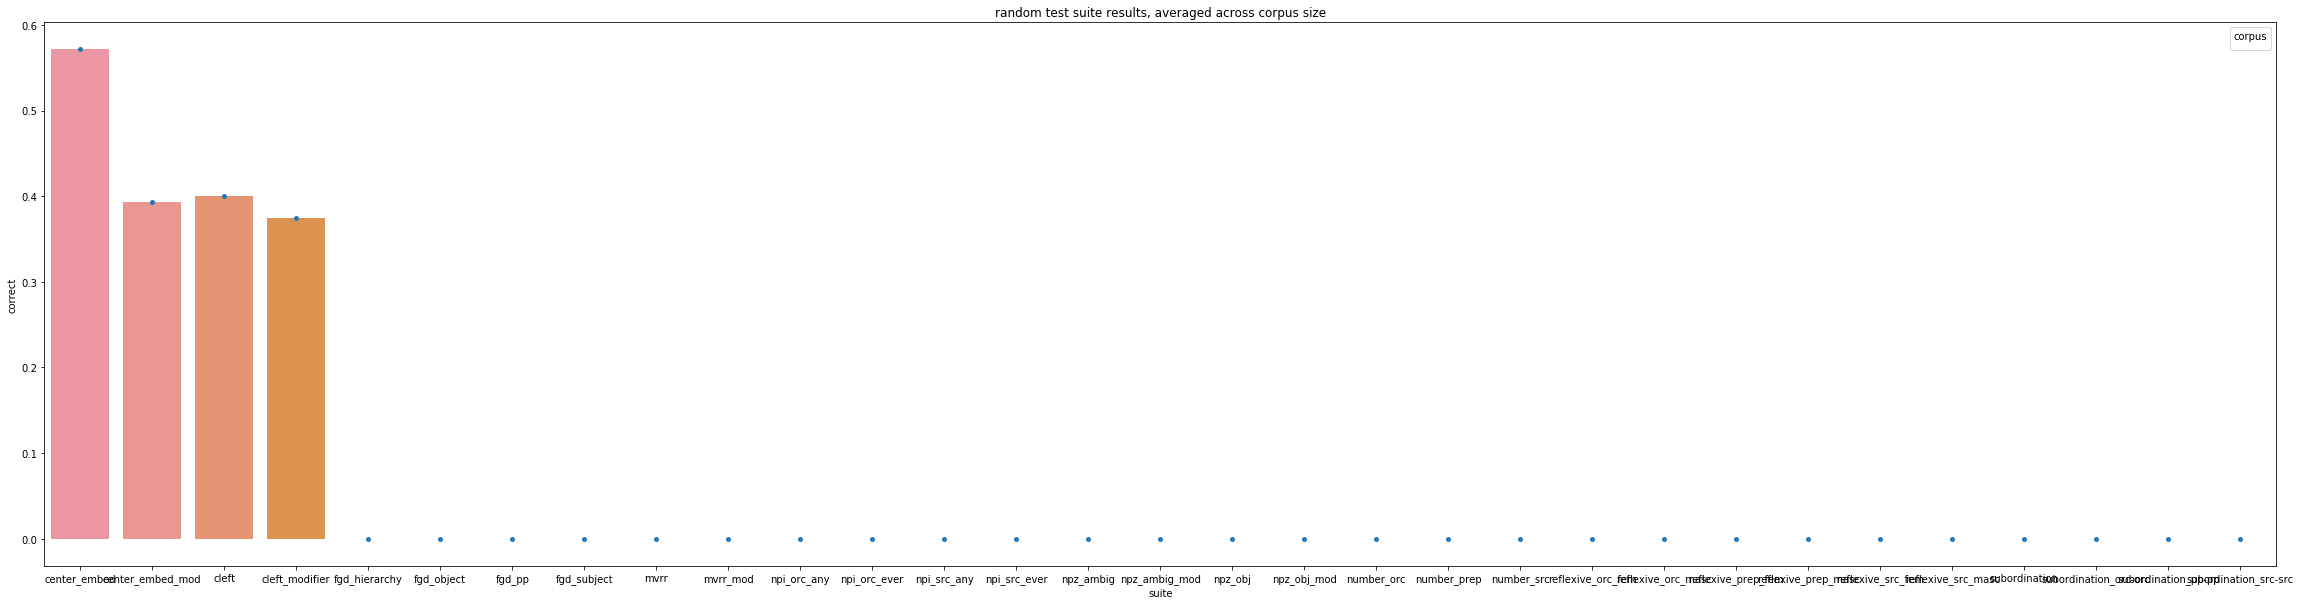

In [17]:
baselines_to_plot = set(baseline_models) & set(suites_df.model_name.unique())
f, axs = plt.subplots(len(baselines_to_plot), 1, figsize=(40, 10 * len(baselines_to_plot)))

for baseline_model, ax in zip(baselines_to_plot, np.ravel(axs)):
    sns.barplot(data=suites_df[suites_df.model_name == baseline_model], x="suite", y="correct", ax=ax)
    sns.swarmplot(data=suites_df[suites_df.model_name == baseline_model], x="suite", y="correct", hue="corpus", ax=ax)
    plt.title(f"{baseline_model} test suite results, averaged across corpus size")

### Accuracy across models

Text(0, 0.5, 'Accuracy')

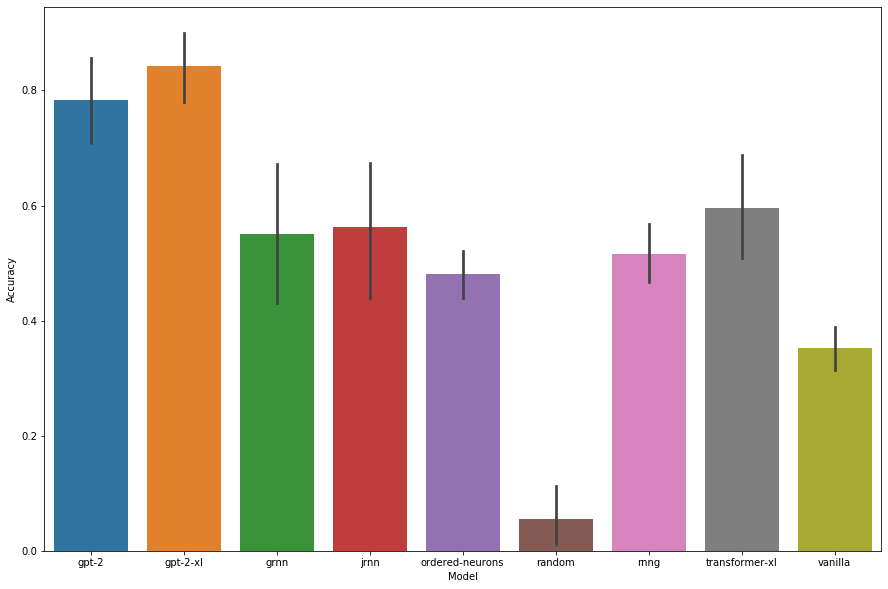

In [18]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=suites_df.reset_index(), x="model_name", y="correct")

plt.xlabel("Model")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

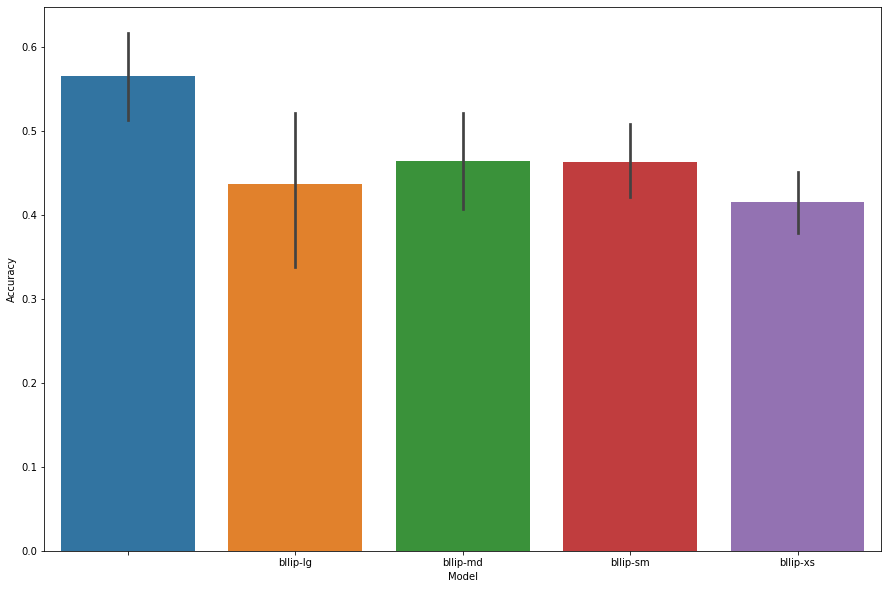

In [19]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=suites_df.reset_index(), x="corpus", y="correct")

plt.xlabel("Model")
plt.ylabel("Accuracy")

Text(0.5, 1.0, 'Model averages: delta from mean accuracy')

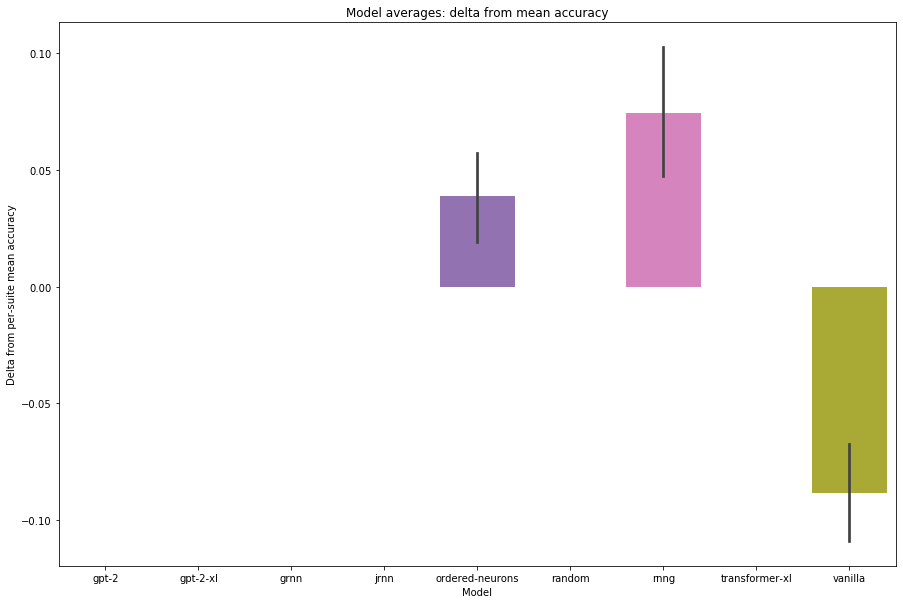

In [20]:
# Compare SG deltas w.r.t. test suite mean rather than absolute values.
# This makes for a more easily interpretable visualization

plt.subplots(figsize=(15, 10))
sns.barplot(data=suites_df.reset_index(), x="model_name", y="correct_delta")

plt.xlabel("Model")
plt.ylabel("Delta from per-suite mean accuracy")
plt.title("Model averages: delta from mean accuracy")

Text(0.5, 1.0, 'Corpus averages: delta from mean accuracy')

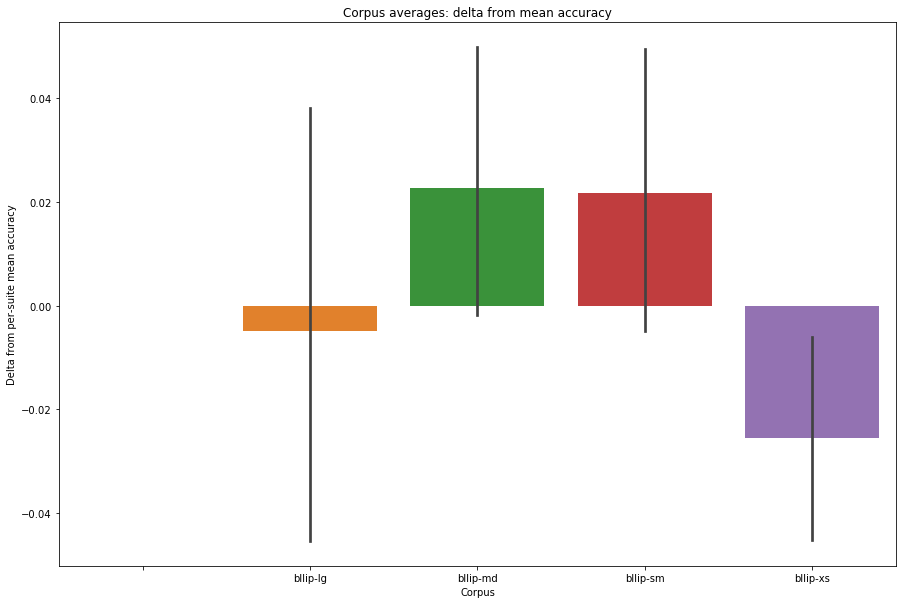

In [21]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=suites_df.reset_index(), x="corpus", y="correct_delta")

plt.xlabel("Corpus")
plt.ylabel("Delta from per-suite mean accuracy")
plt.title("Corpus averages: delta from mean accuracy")

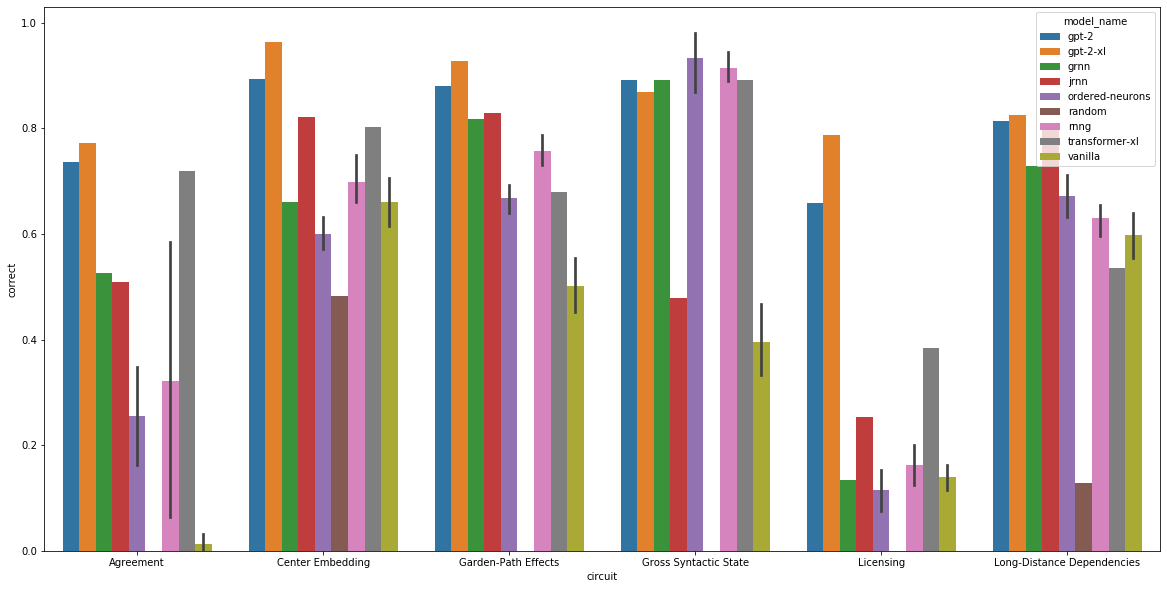

In [22]:
plt.subplots(figsize=(20, 10))
sns.barplot(data=joined_data_circuits, x="circuit", y="correct", hue="model_name")

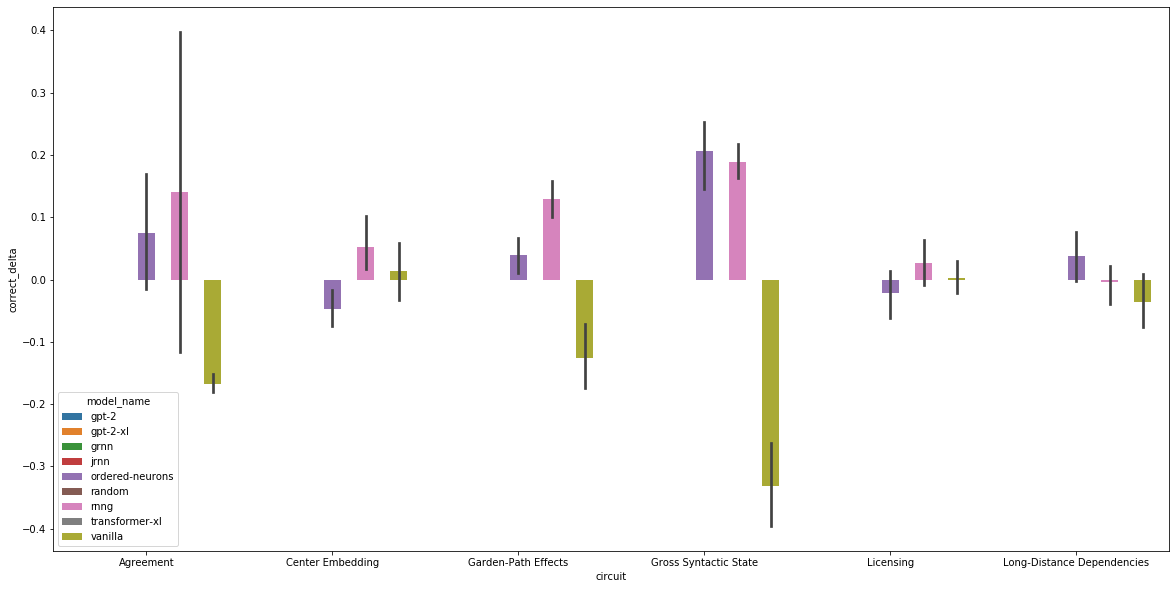

In [23]:
plt.subplots(figsize=(20, 10))
sns.barplot(data=joined_data_circuits, x="circuit", y="correct_delta", hue="model_name")

### Accuracy vs perplexity

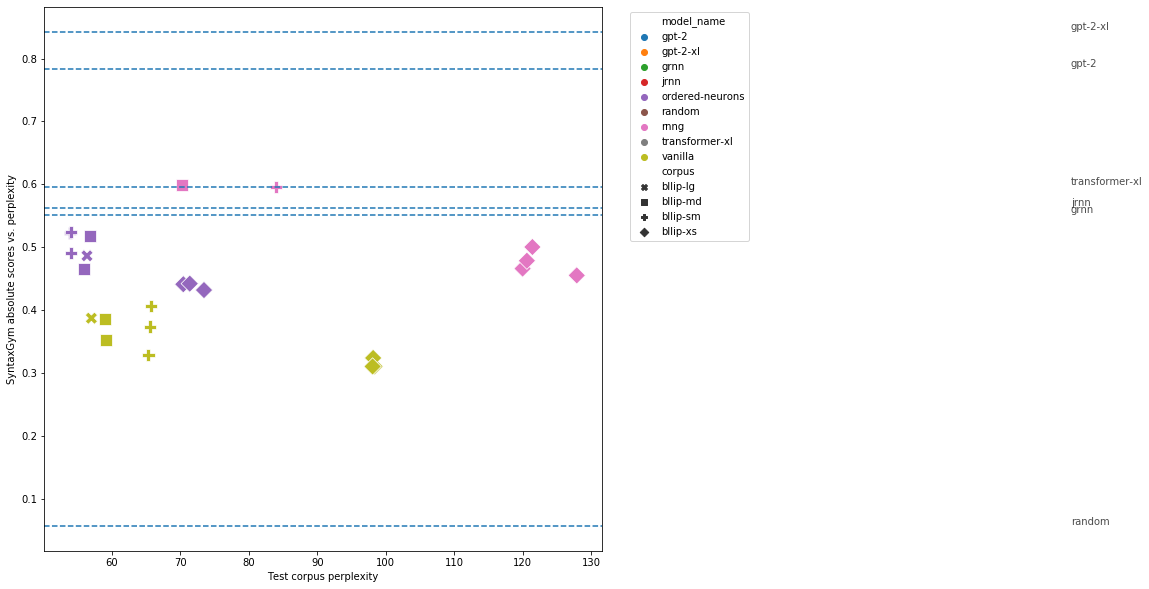

In [24]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=joined_data, x="test_ppl", y="correct",
                hue="model_name", style="corpus", s=150,
                hue_order=model_order)
plt.xlabel("Test corpus perplexity")
plt.ylabel("SyntaxGym absolute scores vs. perplexity")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# Add horizontal lines for models without ppl estimates.
no_ppl_data = joined_data[joined_data.test_ppl.isna()]
for model_name, rows in no_ppl_data.groupby("model_name"):
    y = rows.correct.mean()
    # TODO match legend color
    # TODO show error region?
    ax.axhline(y, linestyle="dashed")
    ax.text(200, y + 0.0025, model_name, alpha=0.7)
    
# TODO add chance line

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


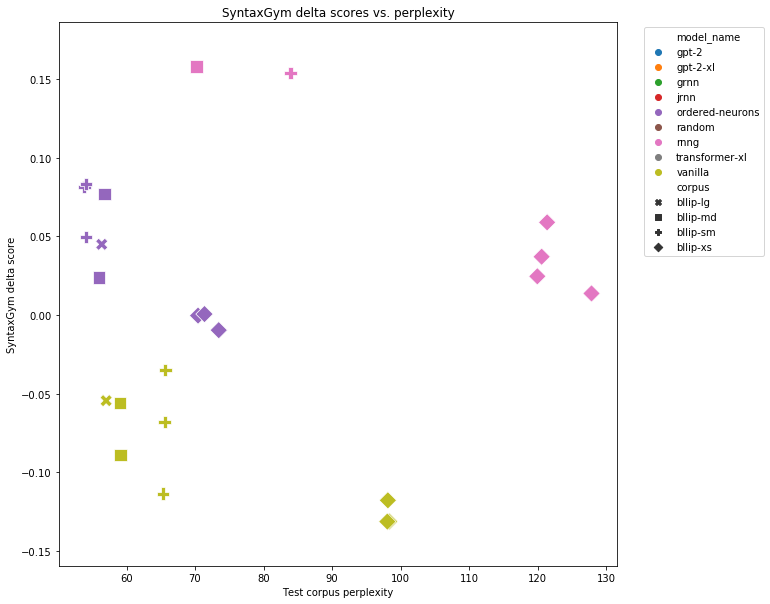

In [25]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=joined_data, x="test_ppl", y="correct_delta",
                hue="model_name", style="corpus", s=150,
                hue_order=model_order)
plt.xlabel("Test corpus perplexity")
plt.ylabel("SyntaxGym delta score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("SyntaxGym delta scores vs. perplexity")
    
# TODO add chance line

(-0.23124610776004995, 0.2578511972134637)

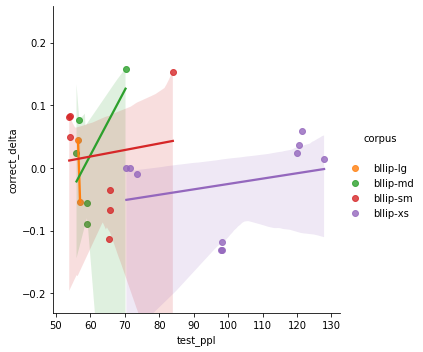

In [26]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct_delta",
               hue="corpus", truncate=True)
g.ax.set_ylim((joined_data.correct_delta.min() - 0.1, joined_data.correct_delta.max() + 0.1))

(-0.23124610776004995, 0.2578511972134637)

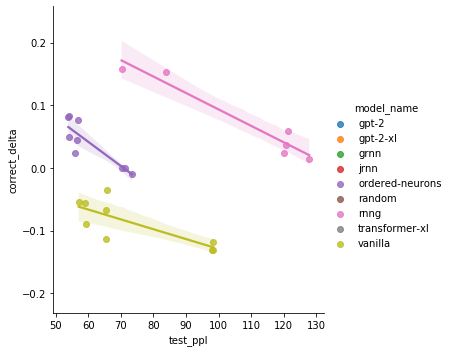

In [27]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct_delta",
               hue="model_name", truncate=True)
g.ax.set_ylim((joined_data.correct_delta.min() - 0.1, joined_data.correct_delta.max() + 0.1))

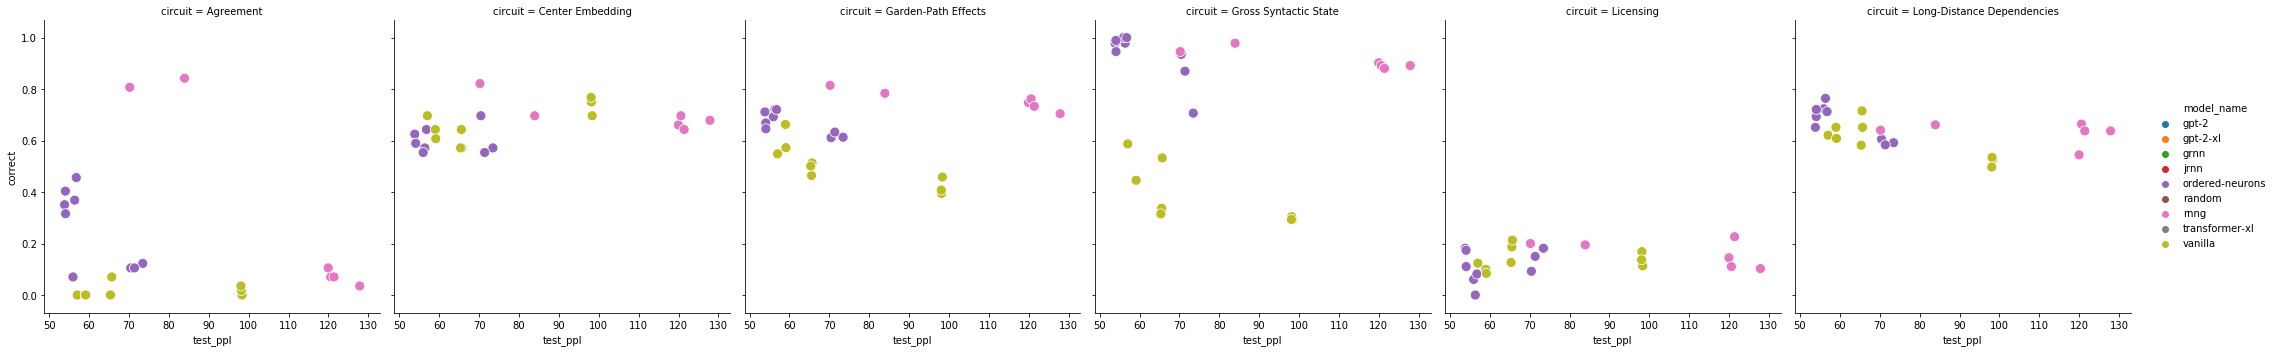

In [28]:
g = sns.FacetGrid(data=joined_data_circuits, col="circuit", height=5)
g.map(sns.scatterplot, "test_ppl", "correct", "model_name",
      hue_order=model_order, s=100)
g.add_legend()

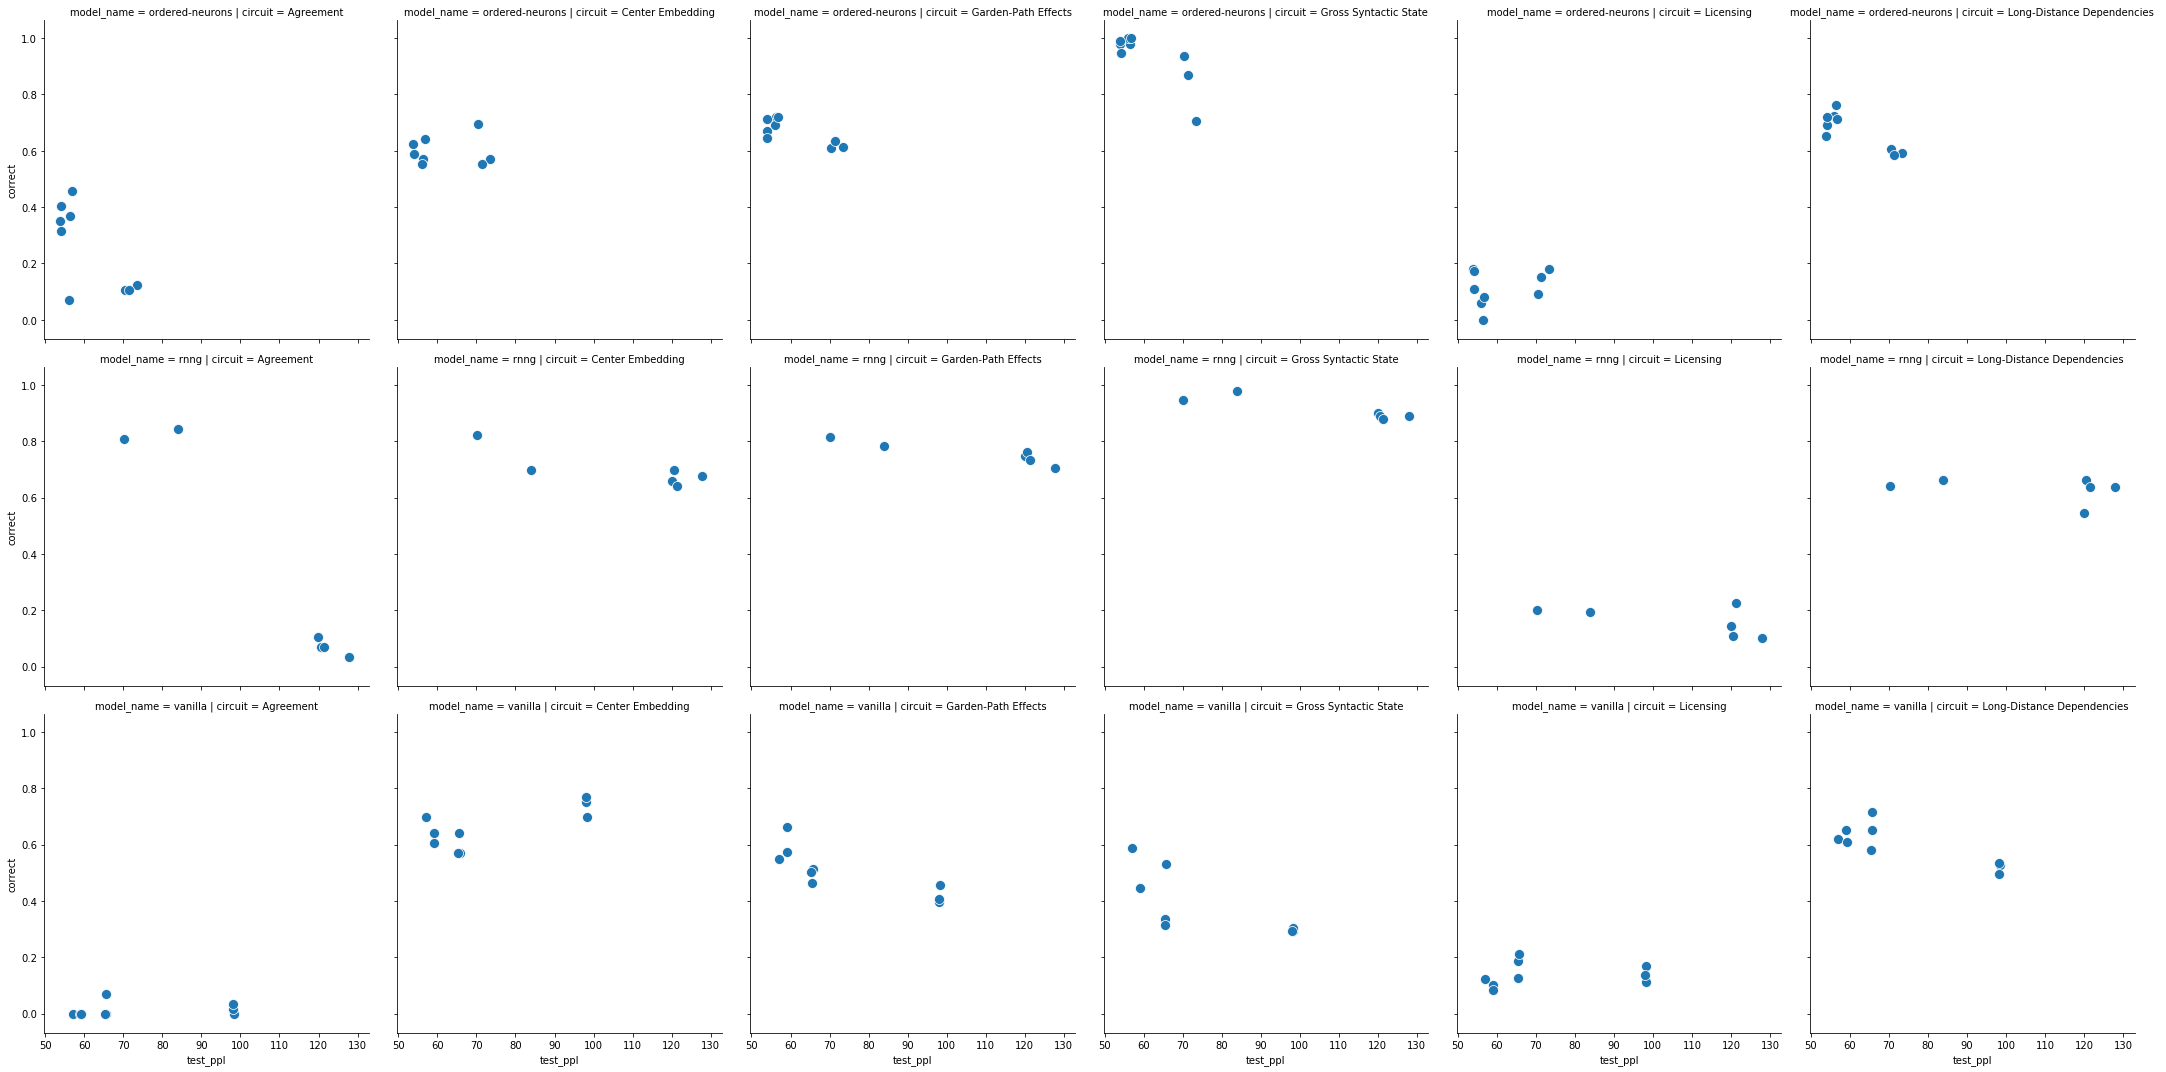

In [29]:
g = sns.FacetGrid(data=joined_data_circuits[~joined_data_circuits.test_ppl.isna()], col="circuit", row="model_name", height=5)
g.map(sns.scatterplot, "test_ppl", "correct",
      hue_order=model_order, s=100)
g.add_legend()

### Item-level statistics

#### Item-level prediction correlations across models

In [30]:
item_predictions = results_df.set_index(["suite", "item"]).sort_index().groupby(["model_name", "corpus", "seed"]).correct.apply(np.array)
model_correlations, model_agreement = [], []
for k1, k2 in itertools.combinations(list(item_predictions.index), 2):
    k1_key = " ".join(map(str, k1))
    k2_key = " ".join(map(str, k2))
    k1_vals = item_predictions.loc[k1]
    k2_vals = item_predictions.loc[k2]
    
    model_correlations.append((k1_key, *k1, k2_key, *k2, stats.spearmanr(k1_vals, k2_vals)[0]))
    model_agreement.append((k1_key, *k1, k2_key, *k2, (k1_vals == k2_vals).mean()))

corr_df = pd.DataFrame(model_correlations, columns=["key_1", "model_1", "corpus_1", "seed_1", "key_2", "model_2", "corpus_2", "seed_2", "corr"])
agree_df = pd.DataFrame(model_agreement, columns=["key_1", "model_1", "corpus_1", "seed_1", "key_2", "model_2", "corpus_2", "seed_2", "agreement"])

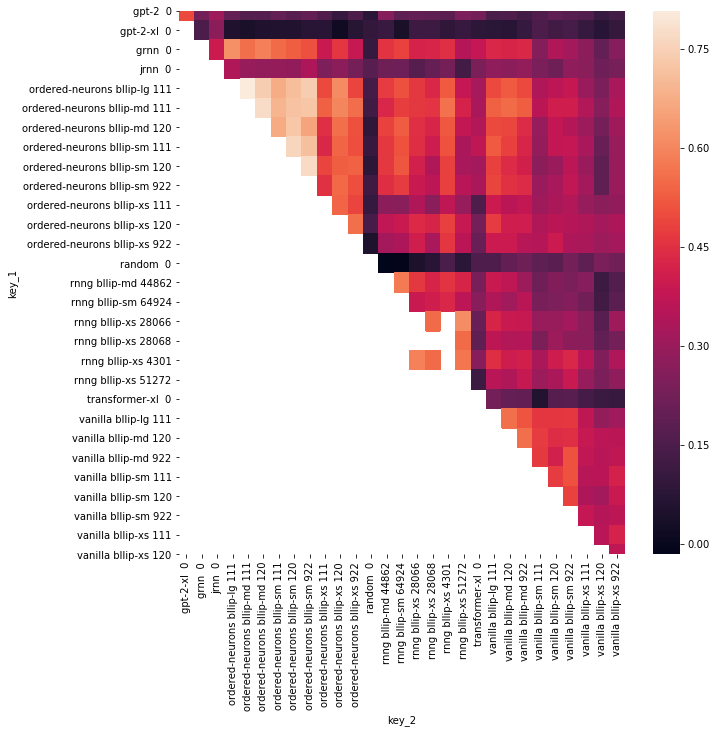

In [31]:
plt.subplots(figsize=(10, 10))
sns.heatmap(data=corr_df.pivot("key_1", "key_2", "corr"))

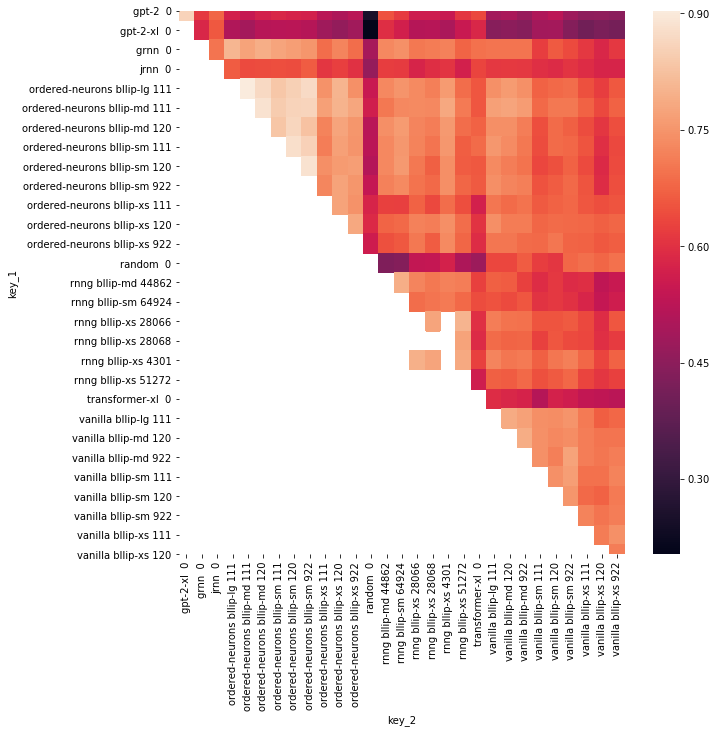

In [32]:
plt.subplots(figsize=(10, 10))
sns.heatmap(data=agree_df.pivot("key_1", "key_2", "agreement"))

Text(0.5, 1.0, 'Distribution of item-level accuracy means')

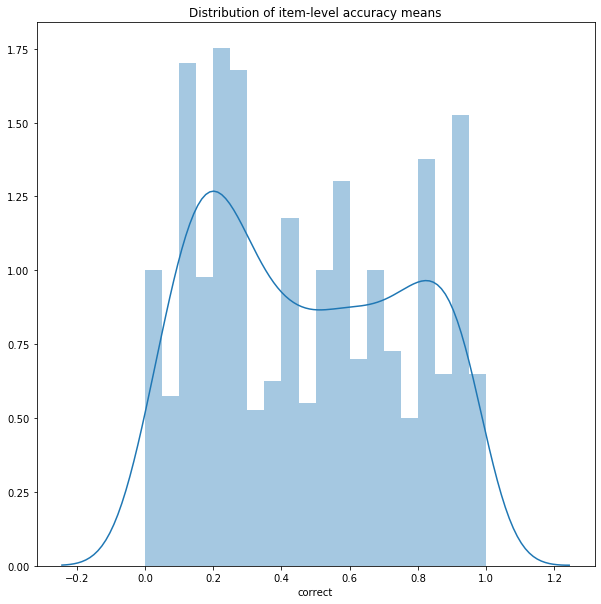

In [33]:
plt.subplots(figsize=(10, 10))
sns.distplot(results_df.groupby(["suite", "item"]).correct.agg("mean"), bins=20)
plt.title("Distribution of item-level accuracy means")

Text(0.5, 1.0, 'Distribution of item-level accuracy stdevs')

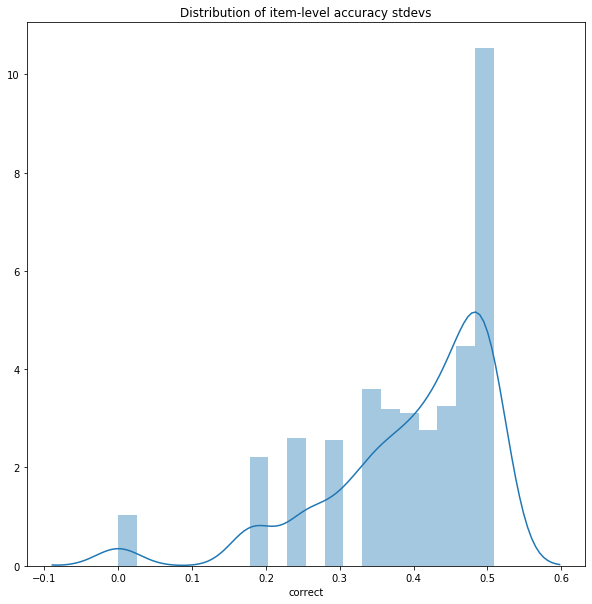

In [34]:
plt.subplots(figsize=(10, 10))
sns.distplot(results_df.groupby(["suite", "item"]).correct.agg("std"), bins=20)
plt.title("Distribution of item-level accuracy stdevs")

Text(0.5, 1.0, 'Distribution of suite-level accuracy means')

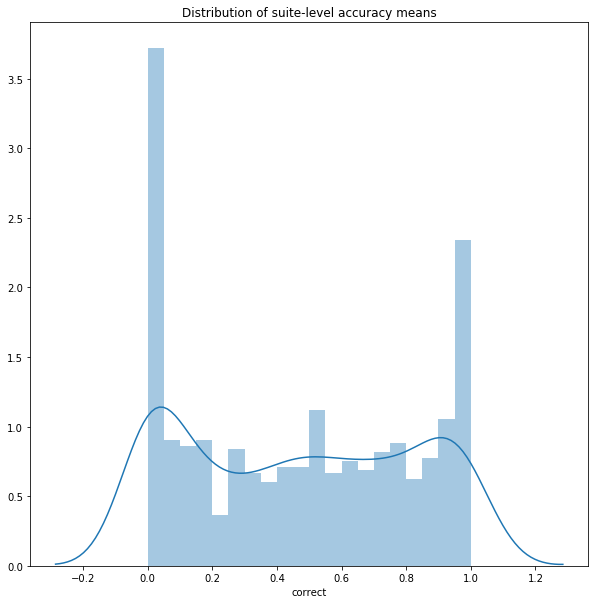

In [35]:
plt.subplots(figsize=(10, 10))
sns.distplot(suites_df.correct, bins=20)
plt.title("Distribution of suite-level accuracy means")

In [65]:
# Get items for which all models fail / succeed
all_fail = results_df[results_df.model_name.isin(controlled_models)].groupby(["suite", "item"]).correct.max() == False
all_succeed = results_df[results_df.model_name.isin(controlled_models)].groupby(["suite", "item"]).correct.min() == True

# Get items for which each condition is true
all_fail = all_fail[all_fail]
all_succeed = all_succeed[all_succeed]

print("All fail\n", all_fail)
print("All succeed\n", all_succeed)

All fail
 suite               item
npi_orc_any         4.0     True
                    5.0     True
                    22.0    True
                    25.0    True
                    27.0    True
npi_src_any         15.0    True
                    16.0    True
                    23.0    True
                    25.0    True
                    35.0    True
number_orc          2.0     True
                    4.0     True
                    14.0    True
                    16.0    True
number_src          4.0     True
                    16.0    True
reflexive_orc_fem   0.0     True
                    1.0     True
                    3.0     True
                    5.0     True
                    6.0     True
                    8.0     True
                    10.0    True
                    12.0    True
                    13.0    True
                    14.0    True
                    15.0    True
                    16.0    True
reflexive_orc_masc  0.0     True
        

### Variance in accuracy vs variance in perplexity

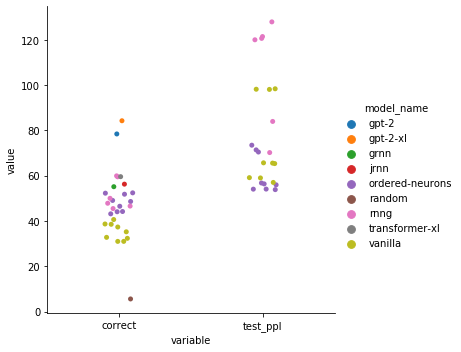

In [36]:
catplot_ticks = ["correct", "test_ppl"]
catplot_data = joined_data.copy()
catplot_data["correct"] *= 100
catplot_data = catplot_data.melt(id_vars=set(catplot_data.columns) - set(catplot_ticks))
# catplot_data["corpus_size"] = catplot_data.corpus.map(corpus_to_size)

g = sns.catplot(data=catplot_data,
                x="variable", y="value", hue="model_name")

## Circuit–circuit correlations

In [37]:
# Exclude some models from circuit correlation analysis.
EXCLUDE_FROM_CIRCUIT_ANALYSIS = ["random", "ngram", "1gram", "ngram-single"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  del sys.path[0]


Text(0.5, 0.98, 'Circuit--circuit correlations')

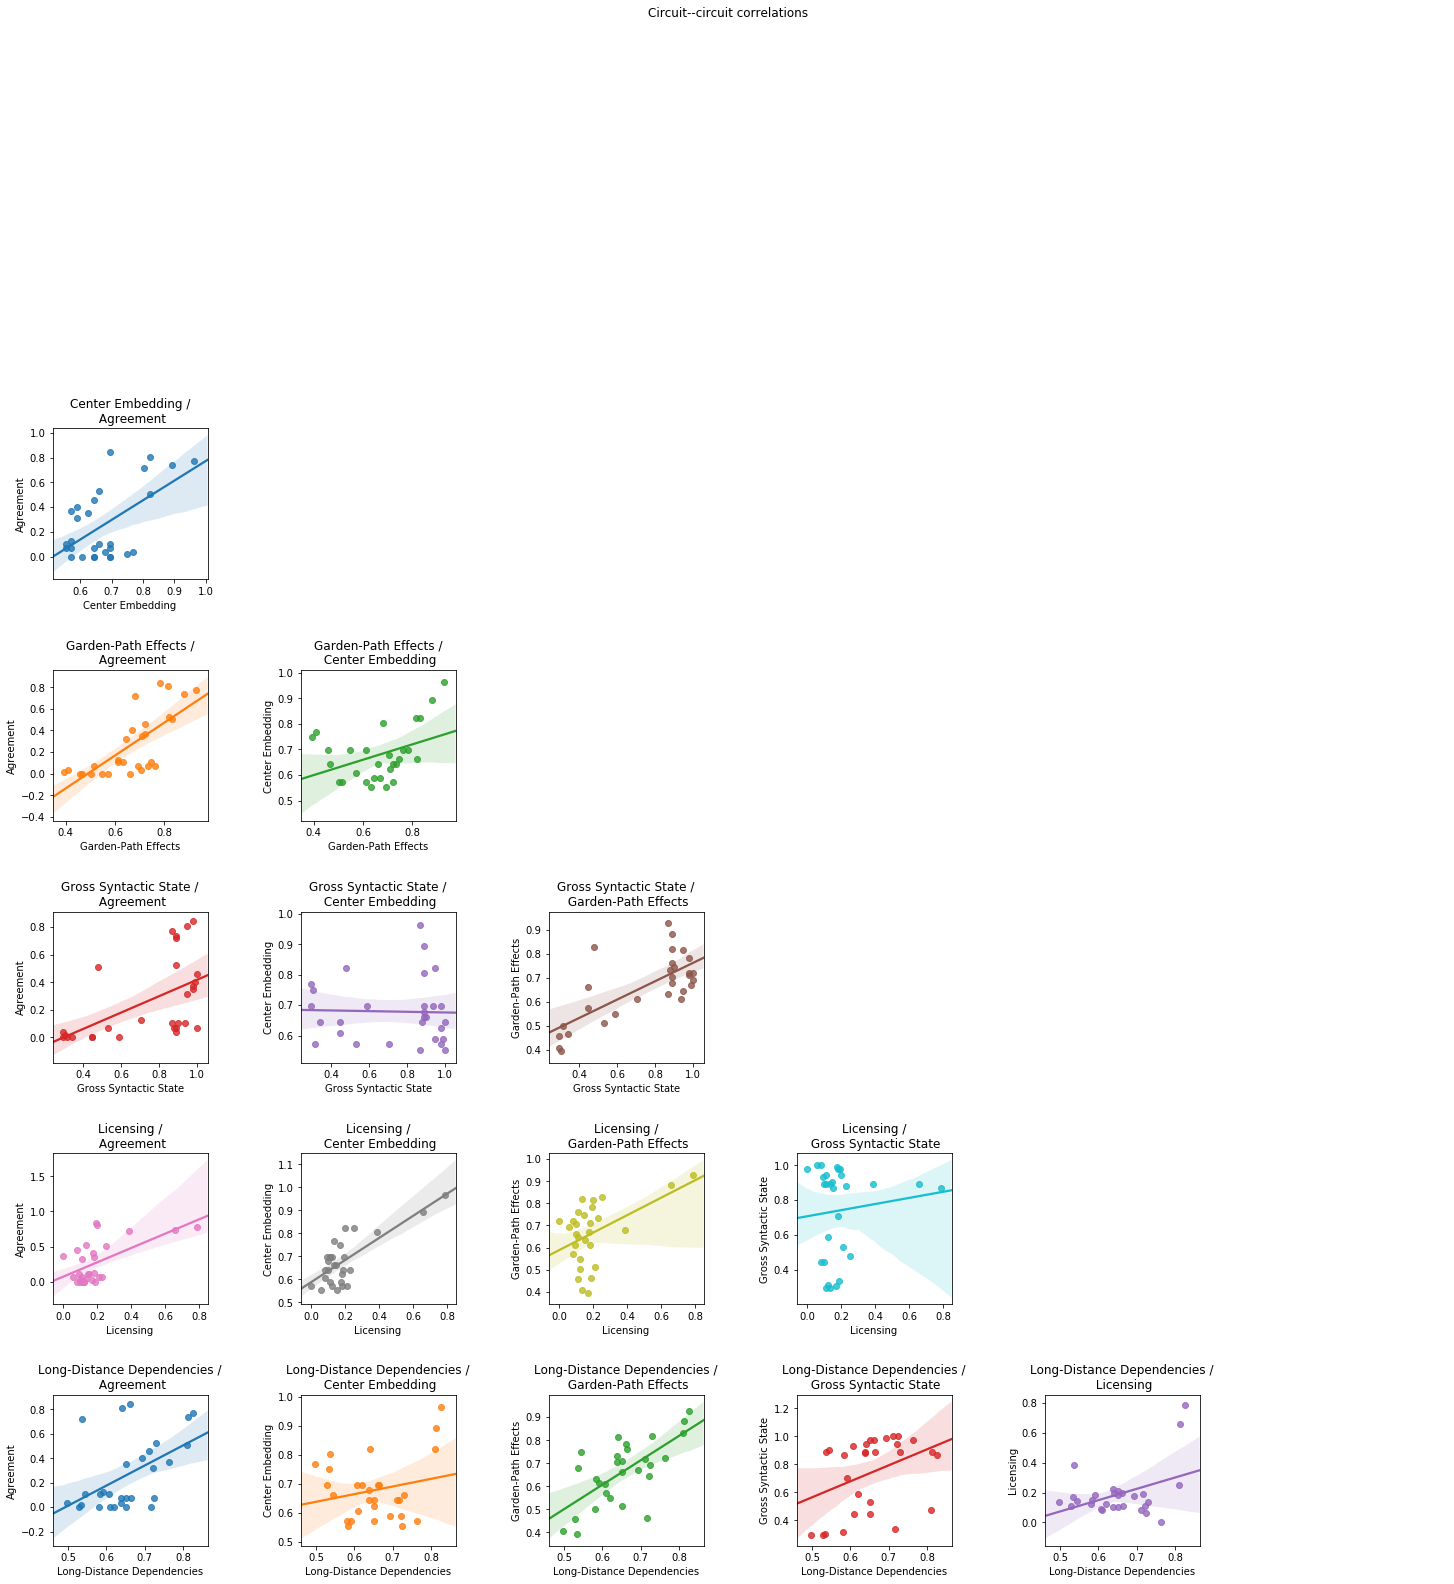

In [38]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(25, 25))
plt.subplots_adjust(hspace=0.6, wspace=0.6)

source_df = suites_df[~suites_df.model_name.isin(EXCLUDE_FROM_CIRCUIT_ANALYSIS)]

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = source_df[source_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
        ys = source_df[source_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s /\n %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax)
        
plt.suptitle("Circuit--circuit correlations")

In [39]:
# Estimate lower-bound Spearman r for each circuit-circuit relation
# by running a structured bootstrap over model--corpus--seeds: randomly
# resample model--corpus--seed combinations and recompute Spearman r's.
def estimate_r(xs):
    # Calculate Spearman-r on bootstrap sample comparing two circuits (shape n * 2)
    corr, pval = stats.spearmanr(xs[:, 0], xs[:, 1])
    return corr

corr_data = pd.DataFrame(index=circuit_order, columns=circuit_order)
n_boot = 500
for c1, c2 in tqdm(list(itertools.combinations(circuit_order, 2))):
    xs = source_df[source_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
    ys = source_df[source_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})

    df = pd.concat([xs, ys], axis=1)
    # Concatenate model--corpus--seed labels to make structured bootstrapping easier.
    df["model_key"] = [" ".join(map(str, key)) for key in df.index.tolist()]
    df = df.reset_index(drop=True)

    corr_data.loc[c1, c2] = sns.utils.ci(sns.algorithms.bootstrap(df, units=df.model_key, n_boot=n_boot, func=estimate_r))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  del sys.path[0]


In [40]:
corr_data

,Agreement,Center Embedding,Garden-Path Effects,Gross Syntactic State,Licensing,Long-Distance Dependencies
Agreement,NaN,"[-0.09622063634685923, 0.6125087377445411]","[0.5434345232510259, 0.8591974283942659]","[0.34029786189315314, 0.7996347259905336]","[0.08892116837109704, 0.7248897317545642]","[0.1374753591937293, 0.7507409270813723]"
Center Embedding,NaN,NaN,"[-0.07640815892709113, 0.6875962422027874]","[-0.5346514651783216, 0.20435201992135804]","[0.07267334097172312, 0.7255269270179743]","[-0.514767197456421, 0.41872206489415587]"
Garden-Path Effects,NaN,NaN,NaN,"[0.2518365997487932, 0.8116737363935977]","[-0.15033715497787248, 0.6375683949471959]","[0.27808206183484796, 0.8638169702146523]"
Gross Syntactic State,NaN,NaN,NaN,NaN,"[-0.5173101126146888, 0.2282246275216389]","[0.12266523903270282, 0.7579914109752017]"
Licensing,NaN,NaN,NaN,NaN,NaN,"[-0.30763388192481217, 0.5126048709343922]"
Long-Distance Dependencies,NaN,NaN,NaN,NaN,NaN,NaN


### Stability to modification

In [48]:
suites_df_mod.suite.unique()

array(['center_embed', 'center_embed_mod', 'cleft', 'cleft_modifier',
       'mvrr', 'mvrr_mod', 'npz_ambig', 'npz_ambig_mod', 'npz_obj',
       'npz_obj_mod'], dtype=object)

Text(0.5, 1.0, 'Stability to modification')

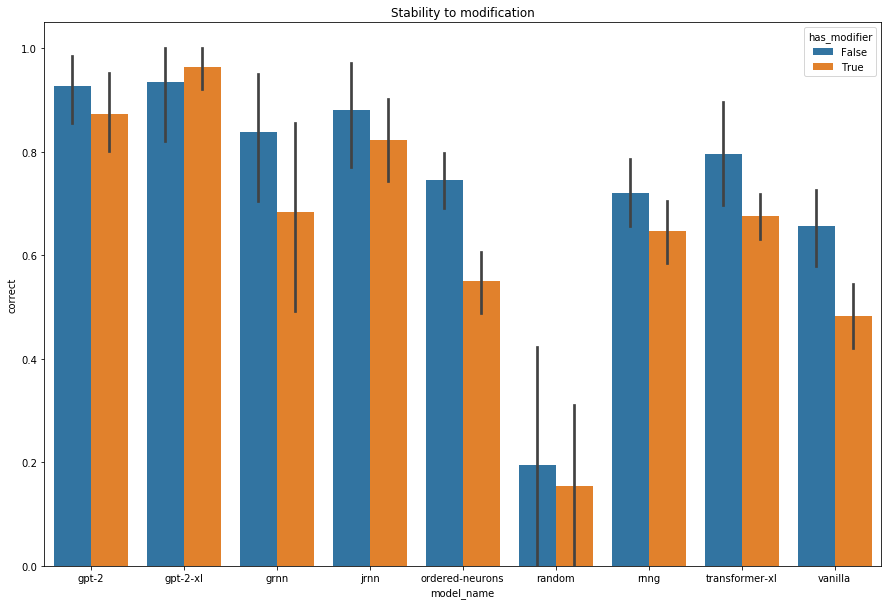

In [49]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=suites_df_mod, x="model_name", y="correct", hue="has_modifier")
plt.title("Stability to modification")

Text(0.5, 1.0, 'Stability to modification')

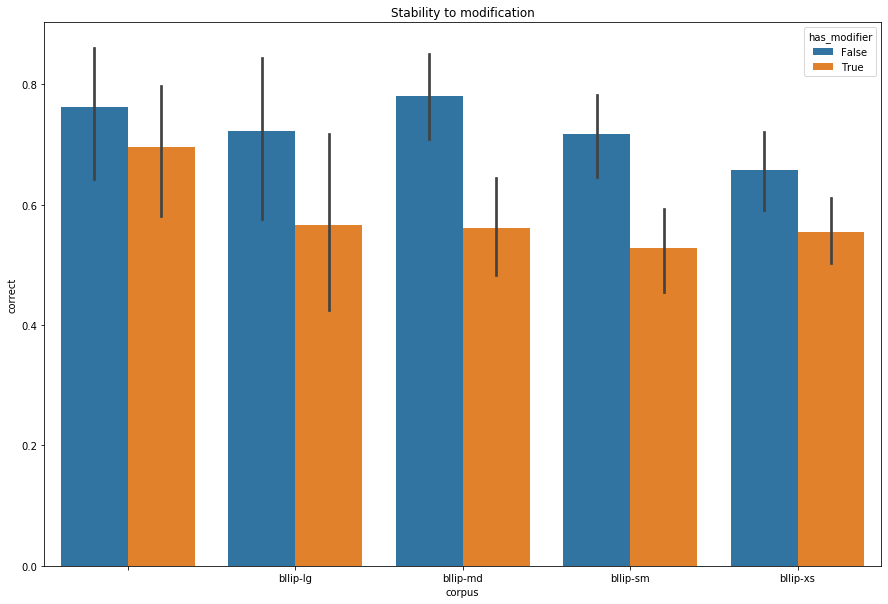

In [50]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=suites_df_mod, x="corpus", y="correct", hue="has_modifier")
plt.title("Stability to modification")

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


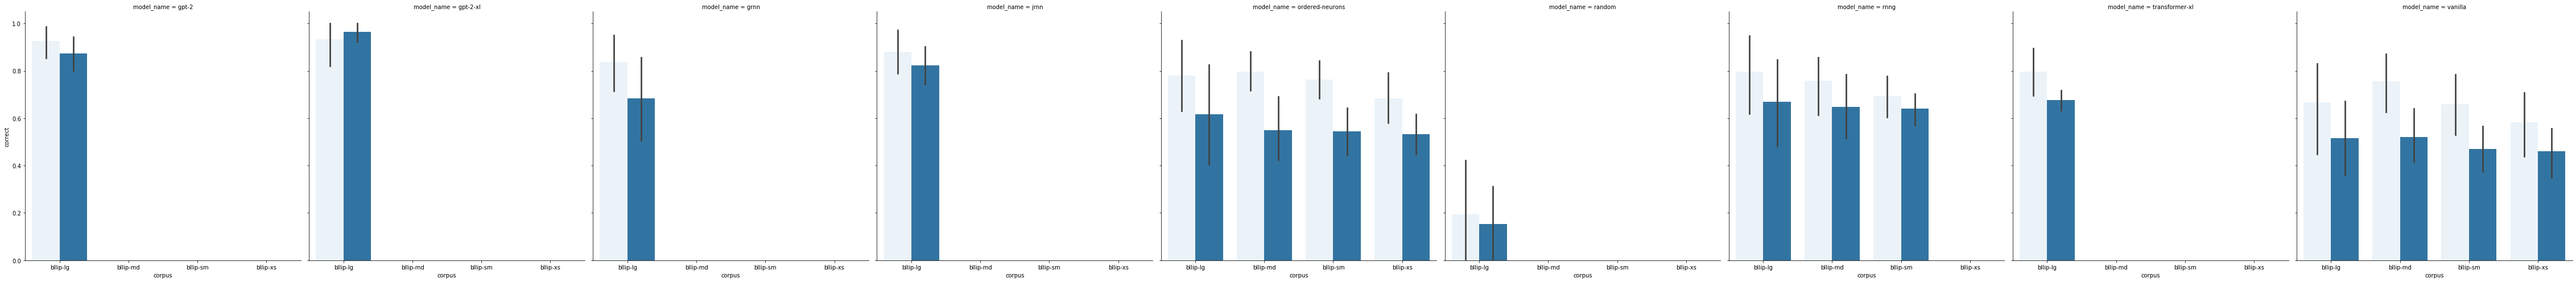

In [51]:
g = sns.FacetGrid(data=suites_df_mod, col="model_name", height=7)
g.map(sns.barplot, "corpus", "correct", "has_modifier")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Change in accuracy due to modification')

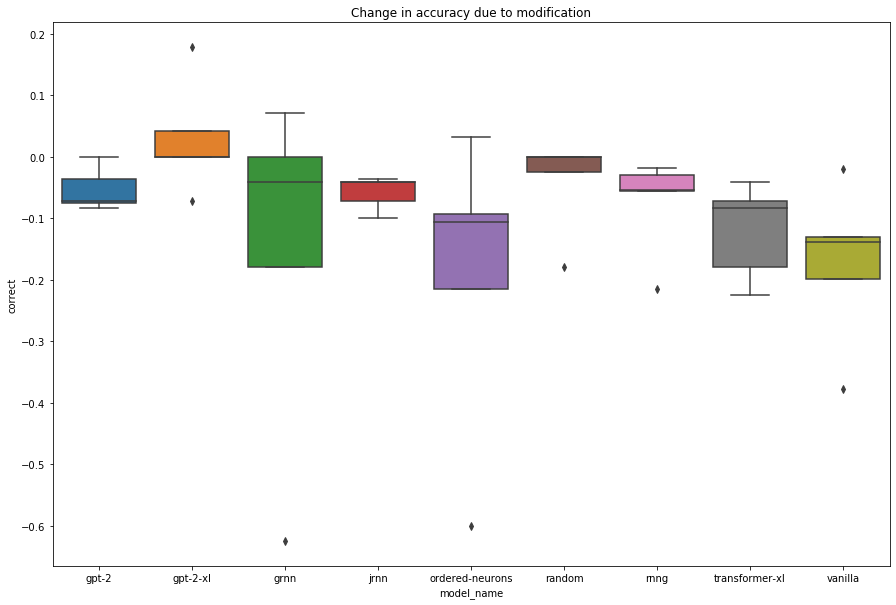

In [52]:
avg_mod_results = suites_df_mod.groupby(["model_name", "test_suite_base", "has_modifier"]).correct.agg({"correct": "mean"}).sort_index()
avg_mod_diffs = avg_mod_results.xs(True, level="has_modifier") - avg_mod_results.xs(False, level="has_modifier")

plt.subplots(figsize=(15, 10))
sns.boxplot(data=avg_mod_diffs.reset_index(), x="model_name", y="correct")
plt.title("Change in accuracy due to modification")

## Quantitative tests

`SG ~ ppl:corpus + model_name + (1 | test_suite)`